# Branched RAG

For an example RAG Router will route between these two branches:

* rag_index: for questions related to agents and prompt engineering
* adv_attack_index: for questions related to adversarial attack

<img src="../images/branched_rag.jpeg">



# Environment 

In [1]:
# %capture --no-stderr
# %pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python nomic[local]

### LLM

In [2]:
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv(override=True)

from genai import Client, Credentials
from genai.extensions.langchain import LangChainInterface
from genai.schema import (
    DecodingMethod,
    TextGenerationParameters,
)
# from langchain_ibm import WatsonxLLM
# from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams


def bam_model(model_id='meta-llama/llama-3-8b-instruct', decoding_method='greedy', max_new_tokens=1000, 
              min_new_tokens=1, temperature=0.5, top_k=50, top_p=1, repetition_penalty=1):

    if decoding_method == 'greedy':
        decoding_method = DecodingMethod.GREEDY
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            repetition_penalty=repetition_penalty
        )
    else:
        decoding_method = DecodingMethod.SAMPLE
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty
        )

    llm = LangChainInterface(
        model_id=model_id,
        client=Client(credentials=Credentials.from_env()),
        parameters=parameters,
    )

    return llm
'''
# def watsonx_model(model_id="mistralai/mixtral-8x7b-instruct-v01", decoding_method='greedy', max_new_tokens=1000, 
#                   min_new_tokens=1, temperature=0.5, top_k=50, top_p=1, repetition_penalty=1):
#     params = {
#         GenParams.DECODING_METHOD: decoding_method,
#         GenParams.MIN_NEW_TOKENS: min_new_tokens,
#         GenParams.MAX_NEW_TOKENS: max_new_tokens,
#         GenParams.RANDOM_SEED: 42,
#         GenParams.TEMPERATURE: temperature,
#         GenParams.TOP_K: top_k,
#         GenParams.TOP_P: top_p,
#         GenParams.REPETITION_PENALTY: repetition_penalty
#     }
#     ibm_cloud_url = os.getenv("IBM_CLOUD_URL", None)
#     project_id = os.getenv("PROJECT_ID", None)
#     api_key = os.getenv("API_KEY")
#     watsonx_llm = WatsonxLLM(
#         model_id=model_id,
#         url=ibm_cloud_url,
#         apikey=api_key,
#         project_id=project_id,
#         params=params,
#     )
#     return watsonx_llm
'''
# prompt = "Tell me about IBM."
# print(f"Prompt: {prompt}")

local_llm = bam_model()
# print(local_llm.invoke(prompt))


# local_llm = "llama3"
model_tested = "meta-llama/llama-3-8b-instruct"
metadata = f"Adaptive_RAG, {model_tested}"

### Tracing

Optionally, use [LangSmith](https://docs.smith.langchain.com/) for tracing (shown at bottom)

In [3]:
import os

os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_ENDPOINT']="https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY']=os.getenv("LANGCHAIN_API_KEY", None)
os.environ['LANGCHAIN_PROJECT']="branched_rag_bam"

# os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY", None)

## Index

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings, HuggingFaceBgeEmbeddings

# Load
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=100
)
doc_splits = text_splitter.split_documents(docs_list)

# Embed and index
embedding = HuggingFaceBgeEmbeddings()

# Index
vectorstore1 = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embedding,
)
retriever1 = vectorstore1.as_retriever()

In [5]:
# Load
url = "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
loader = WebBaseLoader(url)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=100
)
all_splits = text_splitter.split_documents(docs)

# Index
vectorstore2 = Chroma.from_documents(
    documents=all_splits,
    collection_name="rag-chroma1",
    embedding=embedding,
)
retriever2 = vectorstore2.as_retriever()

### Tools

In [20]:
### Router

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

os.environ['TOKENIZERS_PARALLELISM']='true'

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an expert at routing a user question to index_1 or index_2. \n
    Use the index_1 for questions on LLM agents and prompt engineering. \n
    Use the index_2 for questions on LLM adversarial attacks. \n
    You do not need to be stringent with the keywords in the question related to these topics. \n
    Otherwise, use web-search. Give a ternary choice 'index_1', 'index_2' or 'web_search' based on the question. \n
    Return the a JSON with a single key 'datasource' and no premable or explanation. \n
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question to route: {question}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "llm agent memory"

print(question_router.invoke({"question": question}))

docs = retriever1.get_relevant_documents(question)
doc_txt = docs[1].page_content
doc_txt

{'datasource': 'index_1'}


"Memory stream: is a long-term memory module (external database) that records a comprehensive list of agents’ experience in natural language.\n\nEach element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval model: surfaces the context to inform the agent’s behavior, according to relevance, recency and importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are higher-level summaries of past events (<- note that this is a bit different from self-reflection above)\n\nPrompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of observations/statements. Then ask LM to ans

In [21]:
print(question_router.invoke({"question": "Gradient based Attacks"}))
docs = retriever2.get_relevant_documents("Gradient based Attacks")
doc_txt = docs[1].page_content
doc_txt

{'datasource': 'index_2'}


'Per token in the adversarial suffix $t_j, 1 \\leq j \\leq L$, we find the top $k$ values with largest negative gradient of NLL loss, $\\sum_{i=1}^{m_c} \\nabla_{\\textbf{e}_{t_j}} p(\\mathbf{y}^{(i)} \\vert \\mathbf{x}^{(i)}, \\mathbf{t})$, of the language model $p$. And $m_c$ starts at 1.\nThen $B < kL$ token substitution candidates ${\\mathbf{t}^{(1)}, \\dots, \\mathbf{t}^{(B)}}$ are selected out of $kL$ options at random and the one with best loss (i.e. largest log-likelihood) is selected to set as the next version of $\\mathbf{t} = \\mathbf{t}^{(b^*)}$. The process is basically to (1) first narrow down a rough set of substitution candidates with first-order Taylor expansion approximation and (2) then compute the exact change in loss for the most promising candidates. Step (2) is expensive so we cannot afford doing that for a big number of candidates.\nOnly when the current $\\mathbf{t}$ successfully triggers  ${ (\\mathbf{x}^{(i)}, \\mathbf{y}^{(i)}) }_{i=1}^{m_c}$, we increase $m

In [22]:
print(question_router.invoke({"question": "the lord of the rings"}))

{'datasource': 'web_search'}


In [23]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing relevance of a retrieved document to a user question. \n 
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever1.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [24]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 

    Use three sentences maximum and keep the answer concise.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Documents: {documents} 
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = local_llm #ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

 The agent memory is a long-term memory module that records a comprehensive list of agents' experience in natural language. It uses a retrieval model to surface the context to inform the agent's behavior, based on relevance, recency, and importance.


In [25]:
### Hallucination Grader

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [26]:
### Answer Grader

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing whether an answer is useful to resolve a question. \n 
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [27]:
### Question Re-writer

# LLM
llm = local_llm  #ChatOllama(model=local_llm, temperature=0)

# Prompt
re_write_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You a question re-writer that converts an input question to a better version that is optimized \n 
    for vectorstore retrieval. Look at the initial and formulate an improved question. \n
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the initial question: {question}
    provide an improved question with no preamble or explanation: \n 
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'\n\nWhat is agent memory?'

## Web Search Tool

In [28]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Graph 

Capture the flow in as a graph.

## Graph state

In [29]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    index: str
    generation: str
    documents: List[str]

In [41]:
### Nodes

from langchain.schema import Document


def retrieve_index_1(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever1.get_relevant_documents(question)
    return {"documents": documents, "question": question, "index": "index_1"}

def retrieve_index_2(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever2.get_relevant_documents(question)[:2]
    return {"documents": documents, "question": question, "index": "index_2"}



def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"documents": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source["datasource"] == "index_1":
        print("---ROUTE QUESTION TO RAG index_1---")
        return "index_1"
    elif source["datasource"] == "index_2":
        print("---ROUTE QUESTION TO RAG index_2---")
        return "index_2"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"
    
def decide_to_transform_retrieve(state):
    """
    After transform determine whether the next retrival node is 1 or 2

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    index = state["index"]

    if index == "index_1":
        # We will re-generate a new query
        print(
            "---DECISION: TRANSFORM QUERY - index_1 ---"
        )
        return "index_1"
    else:
        print("---DECISION: TRANSFORM QUERY - index_2 ---")
        return "index_2"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Build Graph

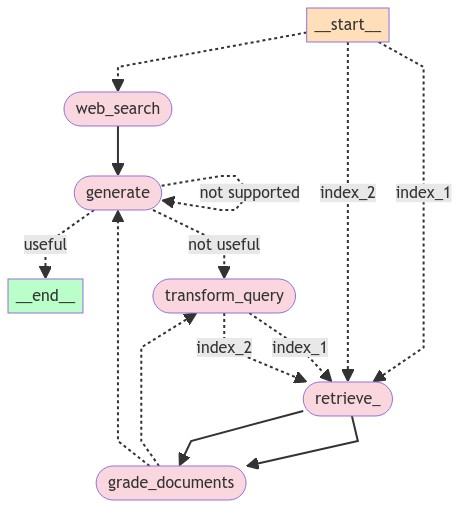

In [42]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve1", retrieve_index_1)  # retrieve1
workflow.add_node("retrieve2", retrieve_index_2)  # retrieve2
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "index_1": "retrieve1",
        "index_2": "retrieve2"
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve1", "grade_documents")
workflow.add_edge("retrieve2", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "transform_query",
    decide_to_transform_retrieve,
    {
        "index_1": "retrieve1",
        "index_2": "retrieve2"
    }
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))


In [43]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
What are the types of agent memory?
{'datasource': 'index_1'}
index_1
---ROUTE QUESTION TO RAG index_1---
---RETRIEVE---
"Node 'retrieve1':"

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"

---

(' The types of agent memory mentioned in the documents are: \n'
 '     - Memory stream: a long-term memory module that records a comprehensive '
 "list of agents' experience in natural language. \n"
 "     - Retrieval model: surfaces the context to inform the agent's behavior, "
 'according to relevance, recency, and importance. \n'
 '     - Reflection mechanism: synthesizes

In [44]:
# Run
inputs = {"question": "What is the theory of relativity?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
What is the theory of relativity?
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"

---

(' The theory of relativity, developed by Albert Einstein, is a fundamental '
 'concept in modern physics that describes the nature of space and time. It '
 'consists of two main components: special relativity and general relativity. '
 'Special relativity reveals that the speed of light is a limit that can be '
 'approached but not reached by any material object, and it has led to other '
 'outcomes such as the "twin paradox." General relativity is concerned with '
 'gravity, one of the fundamental forces in the universe, and it has been '
 'experimentally verified by observations of gravitational lenses, the orbit '


In [45]:
# Run
inputs = {"question": "What is Gradient based Attacks?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
What is Gradient based Attacks?
{'datasource': 'index_2'}
index_2
---ROUTE QUESTION TO RAG index_2---
---RETRIEVE---
"Node 'retrieve2':"

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"

---

(' Gradient-based attacks are a type of white-box attack that relies on '
 'gradient signals to learn an effective attack. They are used to select the '
 'vector to minimize the adversarial loss using only one backward propagation.')
